In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax.config import config
config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

Specify initial setup of the signal, by first loading parameters from the stochastic traveling wave.

In [14]:
signal_params = ConfigDict(KDV_params_traveling)
print(signal_params)

Advection_basis_name: constant
E: 30
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 1
c_4: 0.0
dt: 0.0001
equation_name: KdV
initial_condition: traveling_wave
method: Dealiased_SETDRK4
noise_magnitude: 1.0
nx: 64
tmax: 1.0
xmax: 3.141592653589793
xmin: -3.141592653589793



Next, we specify a signal, by choosing a deterministic solver, 

In [15]:
signal_params.update(E=1,method='Dealiased_SETDRK4',dt=1e-13,tmax= 1e-10,nx = 4*32,P=1,S=0,noise_magnitude=10)

Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [16]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)

In [17]:
key1 = jax.random.PRNGKey(0)
dW = jax.random.normal(key1, shape=(signal_model.nmax, signal_model.params.E, signal_model.params.P))
#dW = -0.1*jnp.ones_like(dW)
dW = dW
final, all = signal_model.run(initial_signal, signal_model.nmax,dW) #the final input is scan length? 
print(final.shape,all.shape)

(1, 128) (1000, 1, 128)


In [18]:
print(type(all))
print(len(all))
print(all[0].shape) # particles
print(all[1].shape) # signal
#out shape is (n_total, n_particles, n_dim)

<class 'jaxlib.xla_extension.ArrayImpl'>
1000
(1, 128)
(1, 128)


In [19]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)
W = jnp.cumsum(dW, axis=0)
W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
print(W.shape)
W_new = jnp.zeros([signal_model.nmax+1, signal_model.params.E, signal_model.params.P])
W_new = W_new.at[1:,:,:].set(W)

E = signal_model.params.E
nmax = signal_model.nmax
nx = signal_model.params.nx
x = signal_model.x
xmax = signal_model.params.xmax
xmin = signal_model.params.xmin
dt = signal_model.params.dt

analytic = jnp.zeros([nmax+1, E, nx])
#analytic = analytic.at[0,:,:].set(initial_signal)
beta = 3.0

#ans = initial_condition( (x - 4*beta**2 * (dt*n) - 1/2*W[n,:,0] + xmax)%(xmax*2) - xmax , E, signal_params.initial_condition)
# print(ans.shape,x.shape, E , W.shape)
initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))

for n in range(signal_model.nmax+1):
    ans = initial_condition_jitted((x - 4*beta**2 * (dt*n) - 1/2*W_new[n,:,:] + xmax)%(xmax*2) - xmax, E, signal_params.initial_condition)
    analytic = analytic.at[n,:,:].set(ans)

# takes a min at higher resolution.


(1, 128)
(1000, 1, 128)
(1001, 1, 128)
(1000, 1, 1)


In [20]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,:,:].T, color='k',linewidth=0.2,label='signal')
    plt.plot(signal_model.x, analytic[da_step,:,:].T, color='r',linewidth=0.2,label='analytic')
    plt.legend()
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.nmax))


(1001, 1, 128) (1001, 1, 128)


interactive(children=(IntSlider(value=500, description='da_step', max=1000), Output()), _dom_classes=('widget-…

<function __main__.plot(da_step)>

In [21]:
def plot(da_step):
    plt.plot(signal_model.x, signal[da_step,:,:].T-analytic[da_step,:,:].T, color='k',linewidth=2)
    plt.legend(['signal'])
    plt.show()
print(signal.shape,analytic.shape)
interact(plot, da_step=(0, signal_model.nmax))

(1001, 1, 128) (1001, 1, 128)


interactive(children=(IntSlider(value=500, description='da_step', max=1000), Output()), _dom_classes=('widget-…

<function __main__.plot(da_step)>

In [22]:
def relative_error(signal, analytic):
    return jnp.linalg.norm(signal-analytic)/jnp.linalg.norm(analytic)

# signal includes the initial condition? but analytic does not?
#print( jnp.linalg.norm(signal[1,:,:]- analytic[1,:,:]))# this should be zero
# 0.627
print(relative_error(signal[:,:,:], analytic[:,:,:]))#space time relative error.

9.510210529746436e-12


In [23]:
a1 = 1.3359985504458728e-05

a2 = 1.4917710093357412e-07

a3 = 9.510210529746436e-12


# looks order 2 to me, as expected, but if dW = 0, check 4th. 

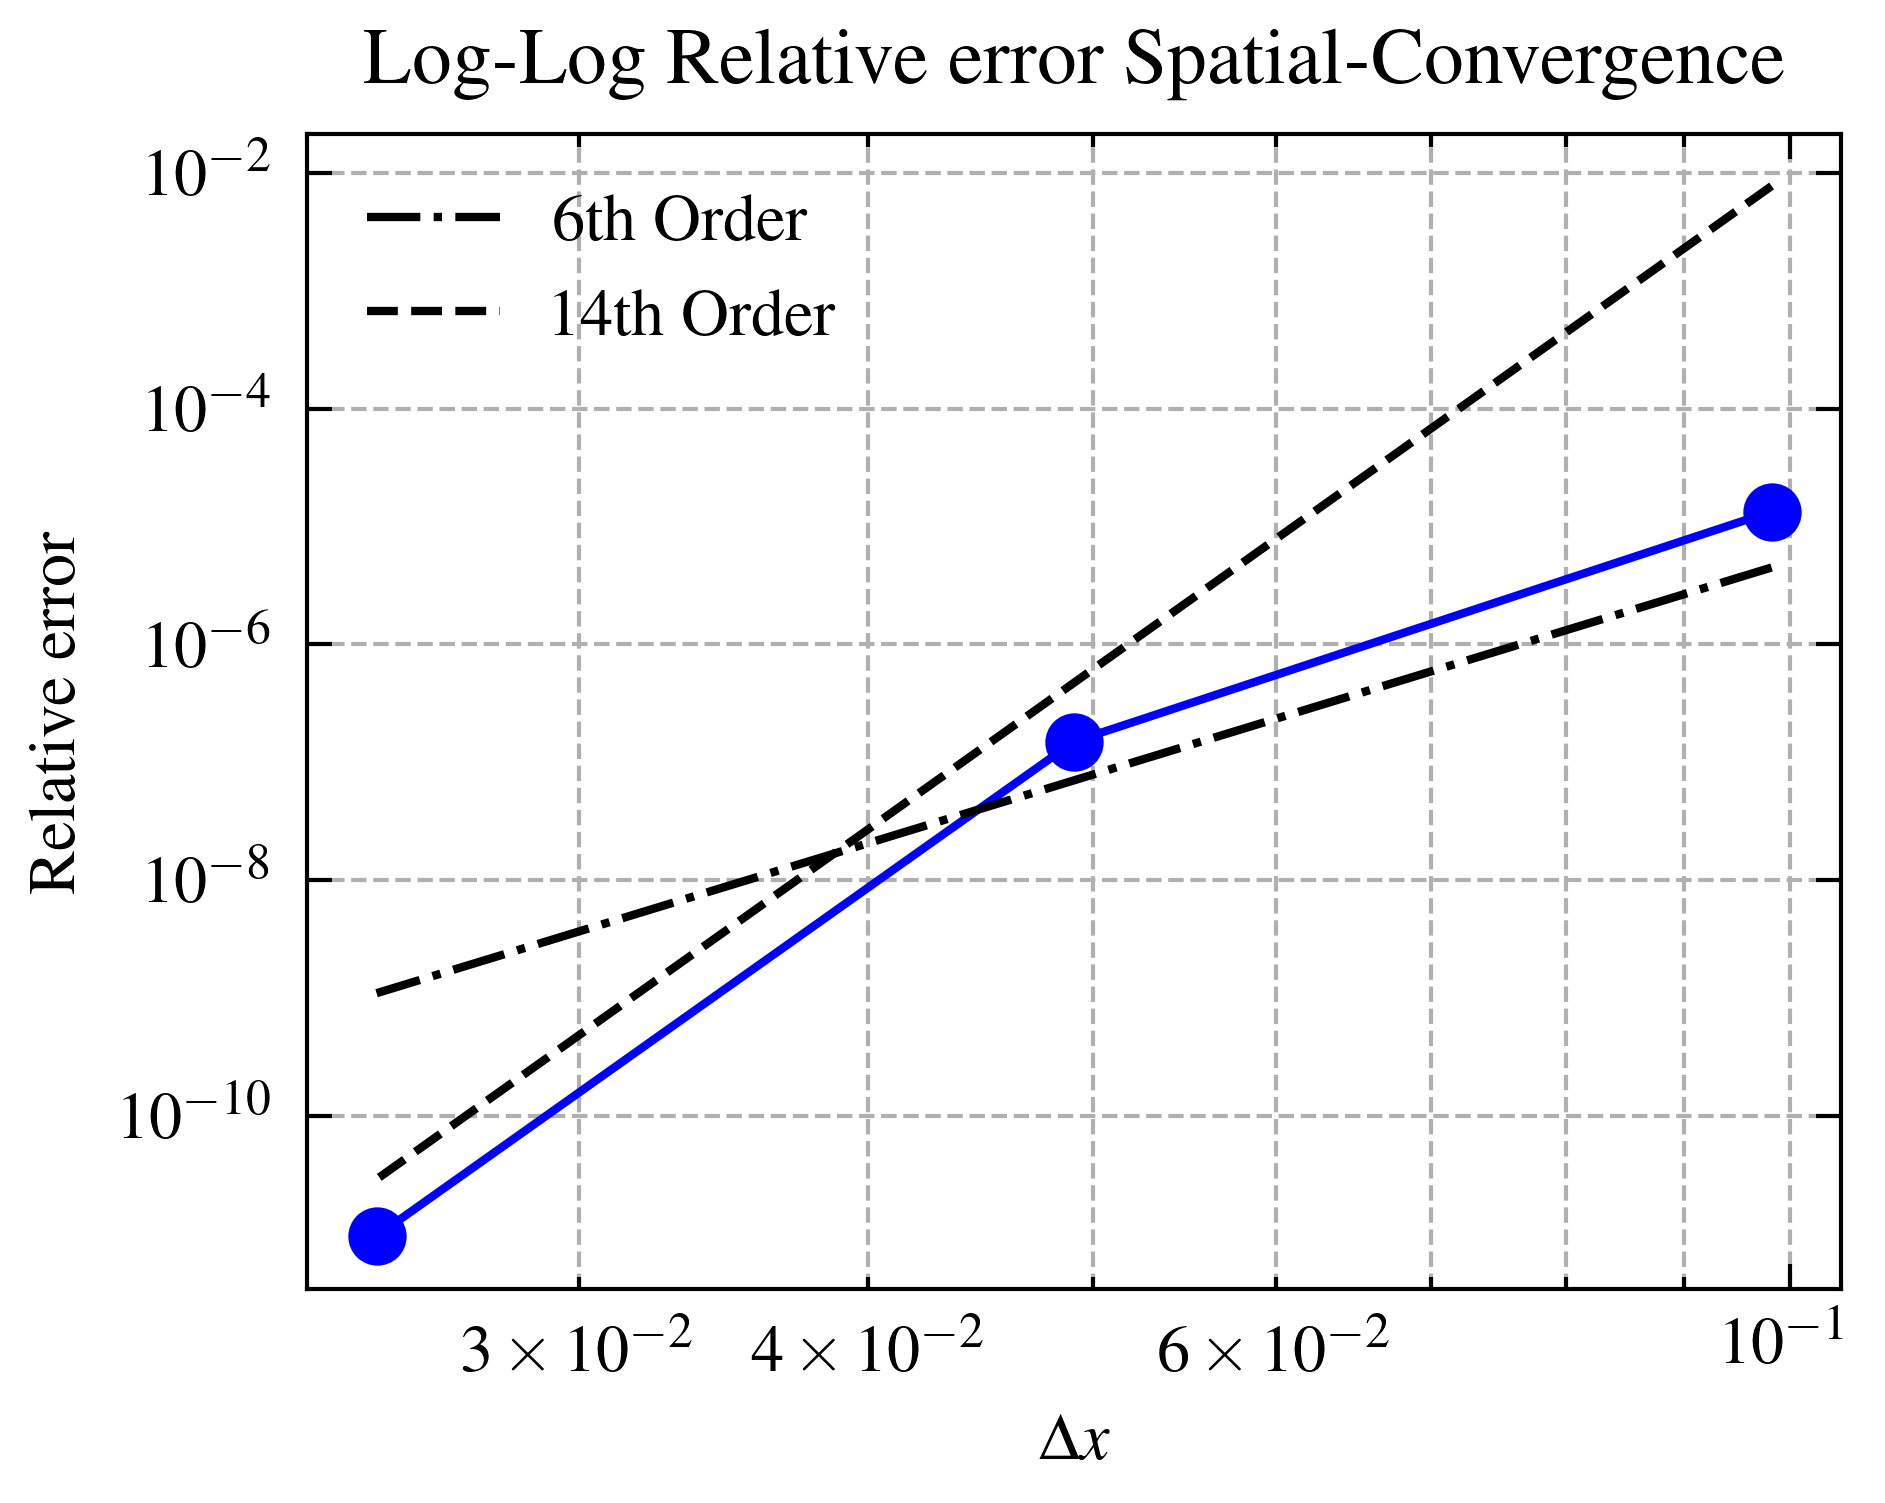

In [24]:
import numpy as np
# Create a list of the two numbers
dx_scale = (xmax - xmin)/64
dx = dx_scale*np.asarray([1.,1/2,1/4])
values = np.asarray([a1, a2, a3])

dt = dx
# Create a log-log plot
plt.figure()
plt.loglog(dt, values, marker='o', linestyle='-', color='b')

plt.loglog(dt,dt**6*5, linestyle='-.', color='k', label='6th Order')
plt.loglog(dt,dt**14*1e12, linestyle='--', color='k', label='14th Order')

plt.xlabel(r'$\Delta x$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error Spatial-Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/convergence_space.png',bbox_inches='tight',dpi=300)
plt.show()
